In [479]:
# Load the data
from pathlib import Path
import pandas as pd
import numpy as np

data_csv = Path("reviews.csv")

if not data_csv.exists():  # Make sure the file exists, otherwise compile it
    from result_compiler import main as data_compiler
    data_compiler()

df = pd.read_csv(data_csv)

# Sort the venues (sources) in the DataFrame as AAAI, IJCAI then ICML, NeurIPS and JAIR, JMLR
source_order = ["AAAI", "IJCAI", "ICML", "NeurIPS", "JAIR", "JMLR"]
df["source"] = pd.Categorical(df["source"], source_order)
# Drop the index column
df.drop("index", axis=1, inplace=True)

# Import the analysis/visualisation libraries
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import latex
pio.kaleido.scope.mathjax = None

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)  

# Define default plot layout
review_categories = ["Implementation", "Data", "Configuration", "Experimental Procedure", "Expertise"]
dimensions = review_categories[:-1]
width = 450
height = 200
layout = dict(
    boxmode="group",
    width=width * (1/0.6),
    height=height * (1/0.6),
    font=dict(
        family="serif",
        size=15,
    ),
    margin=dict(
        t=10,
        b=10,
        l=10,
        r=10,
    ),
    xaxis=dict(
        tickangle=0,
    ),
    yaxis=dict(
        title="Cost",
        range=[1, 10],
        dtick = 1,
    ),
    legend_title=None,
    legend=dict(orientation="h", yanchor="bottom", y=1, xanchor="right", x=1),
)

/var/folders/78/9cl0kydx0g3cdzjyk28yzr7w0000gn/T/ipykernel_44766/2798361481.py:25: DeprecationWarning:


Use of plotly.io.kaleido.scope.mathjax is deprecated and support will be removed after September 2025.
Please use plotly.io.defaults.mathjax instead.




In [480]:
# Drop the theoretical papers as we only analyse experimental
# Measure the amount of theoretical papers that we will have to discount
theoretical_papers = df["theoretical"].sum()
print(f"Total number of theoretical papers: {theoretical_papers}. Percentage: {(theoretical_papers / len(df) * 100).round(4)}%")

df = df[df["theoretical"] == False]
df.drop(["theoretical"], axis=1, inplace=True)

# Drop the award winning papers to avoid bias (The award winning papers are proportionally overrepresented in the dataset)
award_winners = len(df) - df['awards'].isna().sum()
print(f"Total number of award winning papers: {award_winners}.")
df = df[df["awards"].isna()]
df.drop(["awards"], axis=1, inplace=True)
print(f"Total number of applicable papers: {len(df)}")
print()

# Measure the amount of papers that have implementation URLS
print(f"Total number of implementation URLs: {df["implementation_url"].sum()}. Percentage: {(df["implementation_url"].sum() / len(df) * 100).round(4)}%")

# Measure the amount of data sets used and how many were public vs private
avg = (df["public_datasets"].sum() / df["total_datasets"].sum() * 100).round(2)
title = f"Public data sets vs Total Data sets ({avg}%)"
plot = px.bar(df, x="public_datasets", y="total_datasets", title=title)
plot.show()

df["public_data_fraction"] = df["public_datasets"] / df["total_datasets"]
print("Number of papers / percentage that only use private data:", len(df[df["public_datasets"] == 0]), round(len(df[df["public_datasets"] == 0]) / len(df) * 100, 2))
df.drop(["public_datasets", "total_datasets"], axis=1, inplace=True)


# Calculate the papers with implementation url and cost >= 5 based on the guideline
bad_url_count = len(df[(df["implementation_url"] == True) & (df["Implementation"] >= 5)])
print(f"The bad URL count is: {bad_url_count}")



Total number of theoretical papers: 134. Percentage: 14.7091%
Total number of award winning papers: 51.
Total number of applicable papers: 726

Total number of implementation URLs: 453. Percentage: 62.3967%


Number of papers / percentage that only use private data: 29 3.99
The bad URL count is: 45


## Plot the dimension per Venue

In [494]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Step 1: Melt DataFrame using your dimensions
melted_df = df.melt(
    id_vars='source',
    value_vars=dimensions,
    var_name='Dimension',
    value_name='Cost'
)

# Step 2: Count occurrences
counts = (
    melted_df
    .groupby(['Dimension', 'source', 'Cost'])
    .size()
    .reset_index(name='count')
)

# Step 3: Normalize per (Dimension, source)
counts['total'] = counts.groupby(['Dimension', 'source'])['count'].transform('sum')
counts['percentage'] = counts['count'] / counts['total'] * 100

# Step 4: Convert Cost to string for discrete coloring
counts['Cost_str'] = counts['Cost'].astype(str)

# Step 5: Custom color palette (green → red)
custom_colors = [
    "#45b84a", "#66c2a4", "#99d8c9", "#e5f5f9", "#fee08b",
    "#fdae61", "#f16913", "#d7301f", "#ef3b2c", "#cb181d"
]

# Step 6: Define orders
dimension_order = dimensions

# Step 7: Plot stacked normalized bar chart
fig = px.bar(
    counts,
    x='source',
    y='percentage',
    color='Cost_str',
    facet_col='Dimension',
    barmode='stack',
    color_discrete_sequence=custom_colors,
    category_orders={
        'source': source_order,
        'Cost_str': [str(i) for i in range(1, 11)],
        'Dimension': dimension_order
    },
    title="Normalized Cost Distribution per Venue and Dimension"
)

# Step 9: Add dashed target lines for vars
implementation_rate = [df[df["source"] == source]["implementation_url"].mean() * 100 for source in source_order]
public_data_rate = [df[df["source"] == source]["public_data_fraction"].mean() * 100 for source in source_order]
# Alternative public data rate: The percentage of papers using atleast one or more public datasets?
# public_data_rate = [(df[df["source"] == source]["public_data_fraction"] > 0 ).mean() * 100 for source in source_order]

target_lines = pd.DataFrame({
    'source': source_order,
    'Implementation': implementation_rate,  # Replace with your actual target %
    'Data': public_data_rate,
})

# Melt to long form
target_long = target_lines.melt(
    id_vars='source',
    var_name='Dimension',
    value_name='target'
)

# Map Dimension to subplot index
facet_to_axis = {dim: i + 1 for i, dim in enumerate(dimension_order)}
source_pos = {label: i for i, label in enumerate(source_order)}
bargap = 0.05  # match your chart layout

# Add dashed line traces
first_line = True
for _, row in target_long.iterrows():
    dim = row['Dimension']
    if dim not in ['Implementation', 'Data']:
        continue

    facet_num = facet_to_axis[dim]
    xref = 'x' if facet_num == 1 else f'x{facet_num}'
    yref = 'y' if facet_num == 1 else f'y{facet_num}'

    pos = source_pos[row['source']]
    #total = len(source_order)

    # Convert categorical position to domain (0–1 range)
    x0 = (pos - 0.455)# / total
    x1 = (pos + 0.455)# / total

    fig.add_shape(
        type='line',
        x0=x0,
        x1=x1,
        y0=row['target'],
        y1=row['target'],
        xref=xref,
        yref=yref,
        line=dict(color='black', dash='dot', width=1, ),
        layer='above',
    )
    fig.add_trace(go.Scatter(
        x=[row['source'], row['source']],
        y=[row['target'], row['target']],
        mode='lines',
        line=dict(
            color='black',
            dash='dot',   # or 'dash', 'longdash', etc.
            width=2
        ),
        name='Public %',           # this adds it to the legend
        showlegend=first_line,   # only show it once!
        legendrank=999,
        hovertext=f'{row['target']:.2f}% Public',
        hoverinfo='text',
        xaxis=xref,
        yaxis=yref
    ))
    first_line = False

# Step 8: Clean layout and reverse legend
fig.update_layout(
    legend_traceorder="reversed",
    bargap=0.05,
    xaxis_title="",
    yaxis_title="% of Papers",
    legend_title="Cost",
    width=1400,
)

for annotation in fig.layout.annotations:
    if annotation.text.startswith("Dimension="):
        annotation.text = annotation.text.replace("Dimension=", "")
    annotation.font.size = 14  # ← increase title font size here

# Remove all facet x-axis titles
fig.for_each_xaxis(lambda ax: ax.update(title_text=""))

# Final render
fig.show()


/var/folders/78/9cl0kydx0g3cdzjyk28yzr7w0000gn/T/ipykernel_44766/960777322.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/78/9cl0kydx0g3cdzjyk28yzr7w0000gn/T/ipykernel_44766/960777322.py:22: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [482]:
implementation_rate = [df[df["source"] == source]["implementation_url"].mean() for source in source_order]
public_data_rate = [df[df["source"] == source]["public_data_fraction"].mean() for source in source_order]
print(source_order)
print(implementation_rate)
print(public_data_rate)

['AAAI', 'IJCAI', 'ICML', 'NeurIPS', 'JAIR', 'JMLR']
[np.float64(0.5217391304347826), np.float64(0.5772357723577236), np.float64(0.6846153846153846), np.float64(0.8016528925619835), np.float64(0.61), np.float64(0.5526315789473685)]
[np.float64(0.9276155717761558), np.float64(0.8657181571815719), np.float64(0.9214468864468865), np.float64(0.9808999081726355), np.float64(0.9654629629629631), np.float64(0.9894736842105264)]


In [499]:
# Check dark pattern percentage for implementation

for source in source_order:
    if source != "JMLR":
        continue
    print(df[(df['source'] == source) & (df['Data'] > 5)][["source", "Data", "title"]])
    #dark_pattern_papers = len(df[(df['source'] == source) & (df['Implementation'] < 4) & (df['implementation_url'] == True)])
    #print(f"{source} Implementation Dark Pattern: {(dark_pattern_papers / len(df[df['source'] == source])) * 100:.4f}%")

# print()
# for source in source_order:
#     light_pattern_papers = len(df[(df['source'] == source) & (df['Implementation'] < 11) & (df['implementation_url'] == False)])
#     print(df[(df['source'] == source) & (df['Implementation'] < 6) & (df['implementation_url'] == False)])
#     lp_df = df[(df['source'] == source) & (df['Implementation'] < 5) & (df['implementation_url'] == False)]
#     print(f"{source} Implementation Light Pattern: {(light_pattern_papers / len(df[df['source'] == source])) * 100:.4f}%")


    source  Data  \
629   JMLR     6   
631   JMLR     6   
640   JMLR     6   
651   JMLR     6   
664   JMLR     8   
669   JMLR     6   
677   JMLR     6   
694   JMLR     6   
714   JMLR     6   
715   JMLR     6   
721   JMLR     6   
728   JMLR     6   
730   JMLR     8   
731   JMLR     6   
732   JMLR     6   
741   JMLR     6   
756   JMLR     6   

                                                                                                                          title  
629                                  On the Robustness to Misspecification of α-posteriors and Their Variational Approximations  
631                                                                         Empirical Risk Minimization under Random Censorship  
640                          Adaptive Greedy Algorithm for Moderately Large Dimensions in Kernel Conditional Density Estimation  
651                                       Semiparametric Inference For Causal Effects In Graphical Models With Hidden V

## Test for significant differences between Venues per Dimension

Now that we have visualised the distributions, we need to find statistical significance before we can make any claims. First we need to check what type of distributions we have:

In [484]:
import scipy
# Check the normality distribution
for source in source_order:
    print(f"{source}:")
    for dimension in review_categories[0:-1]:
        normality_assumption = scipy.stats.normaltest(df[df["source"] == source][dimension].to_numpy())
        if normality_assumption.pvalue < 0.05:
            print(f"\t{source} {dimension} is NOT normally distributed ({normality_assumption.statistic:.2f}, {normality_assumption.pvalue:.2f})")
        else:
            print(f"\t{source} {dimension} IS normally distributed ({normality_assumption})")

AAAI:
	AAAI Implementation is NOT normally distributed (1947.22, 0.00)
	AAAI Data is NOT normally distributed (35.24, 0.00)
	AAAI Configuration is NOT normally distributed (15.36, 0.00)
	AAAI Experimental Procedure is NOT normally distributed (36.18, 0.00)
IJCAI:
	IJCAI Implementation is NOT normally distributed (1289.15, 0.00)
	IJCAI Data is NOT normally distributed (36.10, 0.00)
	IJCAI Configuration is NOT normally distributed (18.00, 0.00)
	IJCAI Experimental Procedure is NOT normally distributed (61.78, 0.00)
ICML:
	ICML Implementation is NOT normally distributed (72.84, 0.00)
	ICML Data is NOT normally distributed (12.35, 0.00)
	ICML Configuration is NOT normally distributed (52.38, 0.00)
	ICML Experimental Procedure is NOT normally distributed (18.42, 0.00)
NeurIPS:
	NeurIPS Implementation is NOT normally distributed (21.00, 0.00)
	NeurIPS Data is NOT normally distributed (36.44, 0.00)
	NeurIPS Configuration is NOT normally distributed (27.90, 0.00)
	NeurIPS Experimental Procedur

### Apply the Levene test to check if the venues have equal variances
We test this per dimension

In [485]:
for dimension in dimensions:
    venue_samples = []
    for source in source_order:
        venue_samples.append(df[df["source"] == source][dimension].to_numpy())
    levene_result = scipy.stats.levene(*venue_samples, center='median')
    if levene_result.pvalue < 0.05:
        print(f"\t[Brown-Forsythe] {dimension} Variance is NOT homogenous/homoscedastic between venues: {levene_result.statistic:.4f}, p-value: {levene_result.pvalue:.4f}")#
    else:
        print(f"\t[Brown-Forsythe] {dimension} Variance IS homogenous/homoscedastic between venues: {levene_result.statistic:.4f}, p-value: {levene_result.pvalue:.4f}")#
    # fligner_result = scipy.stats.fligner(*venue_samples)
    # if fligner_result.pvalue < 0.05:
    #     print(f"\t[Fligner-Killeen] {dimension} Variance is NOT homogenous/homoscedastic between venues: {fligner_result.statistic:.4f}, p-value: {fligner_result.pvalue:.4f}")#
    # else:
    #     print(f"\t[Fligner-Killeen] {dimension} Variance IS homogenous/homoscedastic between venues: {fligner_result.statistic:.4f}, p-value: {fligner_result.pvalue:.4f}")#

	[Brown-Forsythe] Implementation Variance is NOT homogenous/homoscedastic between venues: 4.9698, p-value: 0.0002
	[Brown-Forsythe] Data Variance IS homogenous/homoscedastic between venues: 1.0647, p-value: 0.3787
	[Brown-Forsythe] Configuration Variance is NOT homogenous/homoscedastic between venues: 2.2778, p-value: 0.0453
	[Brown-Forsythe] Experimental Procedure Variance is NOT homogenous/homoscedastic between venues: 4.9089, p-value: 0.0002


Thus we can conclude that none of the dimensions per venue are normally distributed.

Secondly, we can check if there are significant differences among the groups, using for example

1. ANOVA -> Not recommended due to non-normality and non equal variances(?)
2. Kruskal-Wallis, an extenstion of the Mann-Whitney-U test

In [486]:
from statsmodels.stats.anova import AnovaRM
import pingouin

# I would like to know if there is a significant difference of the mean/average cost between sources

#anova_res = AnovaRM(data=df[df["source"].isin(venue_selection)], depvar="Average", subject="source", within=["years"], aggregate_func="mean").fit()

# One-way ANOVA
# The detailed ANOVA summary table includes the following columns:

# SS : sums of squares
# DF : degrees of freedom
# MS : mean squares (= SS / DF)
# F : F-value (test statistic)
# p_unc : uncorrected p-values
# np2 : partial eta-square effect size *
for dimension in review_categories[:-1]:
    print(f"{dimension}:")
    anova = pingouin.anova(data=df, dv=dimension, between="source", detailed=True)
    print(f"\tANOVA: {anova.iloc[0]['F']:.4f}, p-value: {anova.iloc[0]['p-unc']:.4f}")
    #print(anova.iloc[0])
    #print()
    samples = []
    for venue in source_order:
        samples.append(df[df["source"] == venue][dimension].to_list())
    res = scipy.stats.kruskal(*samples)
    print(f"\tKruskal-Wallis Statistic: {res.statistic:.2f}, p-value: {res.pvalue:.4f}")
    print()
#pingouin.mixed_anova(data=df, dv="Average", within="year", between="source")
#print(df.anova("Average", "source"))

#print(df.rm_anova("Average", within="source", subject="year",))

#pingouin.mixed_anova(data=df[df["source"].isin(venue_selection)], dv="Average", subject="source", within="year", between="year")#within="source", subject="year")


Implementation:
	ANOVA: 5.1879, p-value: 0.0001
	Kruskal-Wallis Statistic: 18.02, p-value: 0.0029

Data:
	ANOVA: 2.6159, p-value: 0.0235
	Kruskal-Wallis Statistic: 19.58, p-value: 0.0015

Configuration:
	ANOVA: 4.1557, p-value: 0.0010
	Kruskal-Wallis Statistic: 30.64, p-value: 0.0000

Experimental Procedure:
	ANOVA: 5.8342, p-value: 0.0000
	Kruskal-Wallis Statistic: 26.25, p-value: 0.0001



Although the ANOVA test assumptions are not met, for comparison we present them here. The Kruskal-Wallis test shows that a significant difference between groups exists. Now we can dig a bit deeper what these differences are.

## Testing for differences in Distributions

We are interested in knowing if some venues 'score better', e.g. have lower costs than others. Thus we are interested in one-sided tests.

There are quite a few possibilities regarding statistical tests:

1. Permutation tests
    - Handles ties well, and we have alot of ties.
    - If group labels were arbitrary, how extreme is the observed difference in our chosen metric?
2. The Mann-Whitney U test, aka Wilcoxon rank-sum test -> Handles ties well, works for median/location shift?
    - Are the values in one group consistently higher/lower in rank?
3. ~~KS-Test -> Is sensitive to ties, not ideal for discrete data, test the entire distribution for difference~~
6. ~~Friedman Test -> Not possible due to different sample sizes~~
7. ~~The Wilcoxon test -> does not work with unequal sample sizes~~

### Permutation test

In [487]:
# We apply the test over the mean
def statistic_func(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

tables = [
    np.round(np.random.rand(6, 6, 2), 3)  # shape: (6, 6, 2)
    for _ in dimensions
]

for dim_index, dimension in enumerate(dimensions):
    permutation_df = pd.DataFrame(columns=source_order, index=source_order)#, title=f"Perumutation test {dimension}")
    print(f"{dimension}:")
    for s_index, source in enumerate(source_order):
        any_true = False
        for so_index, other_source in enumerate(source_order):
            x, y = df[df["source"] == source][dimension].to_numpy(), df[df["source"] == other_source][dimension].to_numpy()
            test_res_perm = scipy.stats.permutation_test([x, y],
                                                          statistic_func,
                                                          n_resamples=999999,
                                                          alternative="less")

            test_res_mwu = scipy.stats.mannwhitneyu(x, y, alternative="less")
            #  Benjamini-Hochberg p-value adjustment:
            test_res_perm_pvalue = scipy.stats.false_discovery_control(test_res_perm.pvalue)  # This is not how you do this, it should be over an array of p-values
            test_res_mwu_pvalue = scipy.stats.false_discovery_control(test_res_mwu.pvalue)
            # Bonferonni correction:
            #hypothesis_count = (len(source_order) * len(source_order) - len(source_order)) / 2
            #test_res_perm_pvalue = test_res_perm.pvalue * hypothesis_count
            #test_res_mwu_pvalue = test_res_mwu.pvalue * hypothesis_count
            if (test_res_perm_pvalue < 0.05 or test_res_mwu_pvalue < 0.05) and not any_true:
                any_true = True
                print(f"\t{source}:")
            if (test_res_perm_pvalue < 0.05) != (test_res_mwu_pvalue < 0.05):
                print(f"\t\t\t\t {other_source}: The tests DISAGREE! [Permutation] {test_res_perm.statistic:.4f}  Observed Difference in means ({test_res_perm_pvalue:.4f}) [Mann-Whitney] {test_res_mwu.statistic:.4f} x > y pairs, {(test_res_mwu.statistic / (len(x) * len(y))):.4f}% of pairs ({test_res_mwu_pvalue:.4f})")
            if test_res_perm_pvalue < 0.05:
                print(f"\t\t {source} is less than {other_source}: [Permutation] {test_res_perm.statistic:.4f} Observed Difference in means ({test_res_perm_pvalue:.4f}) [Mann-Whitney] {test_res_mwu.statistic:.4f} x > y pairs, {(test_res_mwu.statistic / (len(x) * len(y))):.4f}% of pairs ({test_res_mwu_pvalue:.4f})")
            
            tables[dim_index][s_index][so_index] = (test_res_perm_pvalue, test_res_mwu_pvalue)
    print()


Implementation:
	ICML:
		 ICML is less than AAAI: [Permutation] -1.5319 Observed Difference in means (0.0002) [Mann-Whitney] 6883.0000 x > y pairs, 0.3837% of pairs (0.0004)
		 ICML is less than IJCAI: [Permutation] -1.1333 Observed Difference in means (0.0070) [Mann-Whitney] 6761.0000 x > y pairs, 0.4228% of pairs (0.0155)
		 ICML is less than JAIR: [Permutation] -0.8700 Observed Difference in means (0.0342) [Mann-Whitney] 5423.5000 x > y pairs, 0.4172% of pairs (0.0144)
		 ICML is less than JMLR: [Permutation] -1.1421 Observed Difference in means (0.0080) [Mann-Whitney] 6046.5000 x > y pairs, 0.4080% of pairs (0.0058)
	NeurIPS:
		 NeurIPS is less than AAAI: [Permutation] -1.8228 Observed Difference in means (0.0000) [Mann-Whitney] 6316.5000 x > y pairs, 0.3783% of pairs (0.0003)
		 NeurIPS is less than IJCAI: [Permutation] -1.4242 Observed Difference in means (0.0008) [Mann-Whitney] 6433.5000 x > y pairs, 0.4323% of pairs (0.0311)
		 NeurIPS is less than JAIR: [Permutation] -1.1609 O

In [488]:
# # Corr
# permutation_p_values = []
# mwu_p_values = []
# #hypothesis_count = (len(source_order) * len(source_order) - len(source_order)) / 2  # Per dimension
# #hypothesis_count = len(source_order) - 1  # Per venue per dimension
# hypothesis_count = 60
# for dimension in tables:
#     dim_list_perm = []
#     dim_list_mwu = []
#     for source in dimension:
#         for other_source in source:
#             dim_list_perm.append(other_source[0] * hypothesis_count)
#             dim_list_mwu.append(other_source[1] * hypothesis_count)
#     #permutation_p_values.extend(list(scipy.stats.false_discovery_control(dim_list_perm)))
#     #mwu_p_values.extend(list(scipy.stats.false_discovery_control(dim_list_mwu)))
#     permutation_p_values.extend(dim_list_perm)
#     mwu_p_values.extend(dim_list_mwu)
# # for x, y in zip(permutation_p_values, scipy.stats.false_discovery_control(permutation_p_values)):
# #     if x < 0.05 or y < 0.05:
# #         print(x, y)
# #     if x < 0.05 and y >= 0.05:
# #         print("\t!!!", x, y)

# #permutation_p_values = scipy.stats.false_discovery_control(permutation_p_values)
# #mwu_p_values = scipy.stats.false_discovery_control(mwu_p_values)

# corrected_tables_bonferroni = [
#     np.round(np.random.rand(6, 6, 2), 3)  # shape: (6, 6, 2)
#     for _ in dimensions
# ]

# index = 0
# for dim_index, dimension in enumerate(dimensions):
#     for s_index, source in enumerate(source_order):
#         for so_index, other_source in enumerate(source_order):
#             #index = dim_index * len(dimensions) + s_index * len(source_order) + so_index * len(source_order)
#             corrected_tables_bonferroni[dim_index][s_index][so_index] = (permutation_p_values[index], mwu_p_values[index])
#             index += 1
# #print(permutation_p_values)
# #print(scipy.stats.false_discovery_control(permutation_p_values))

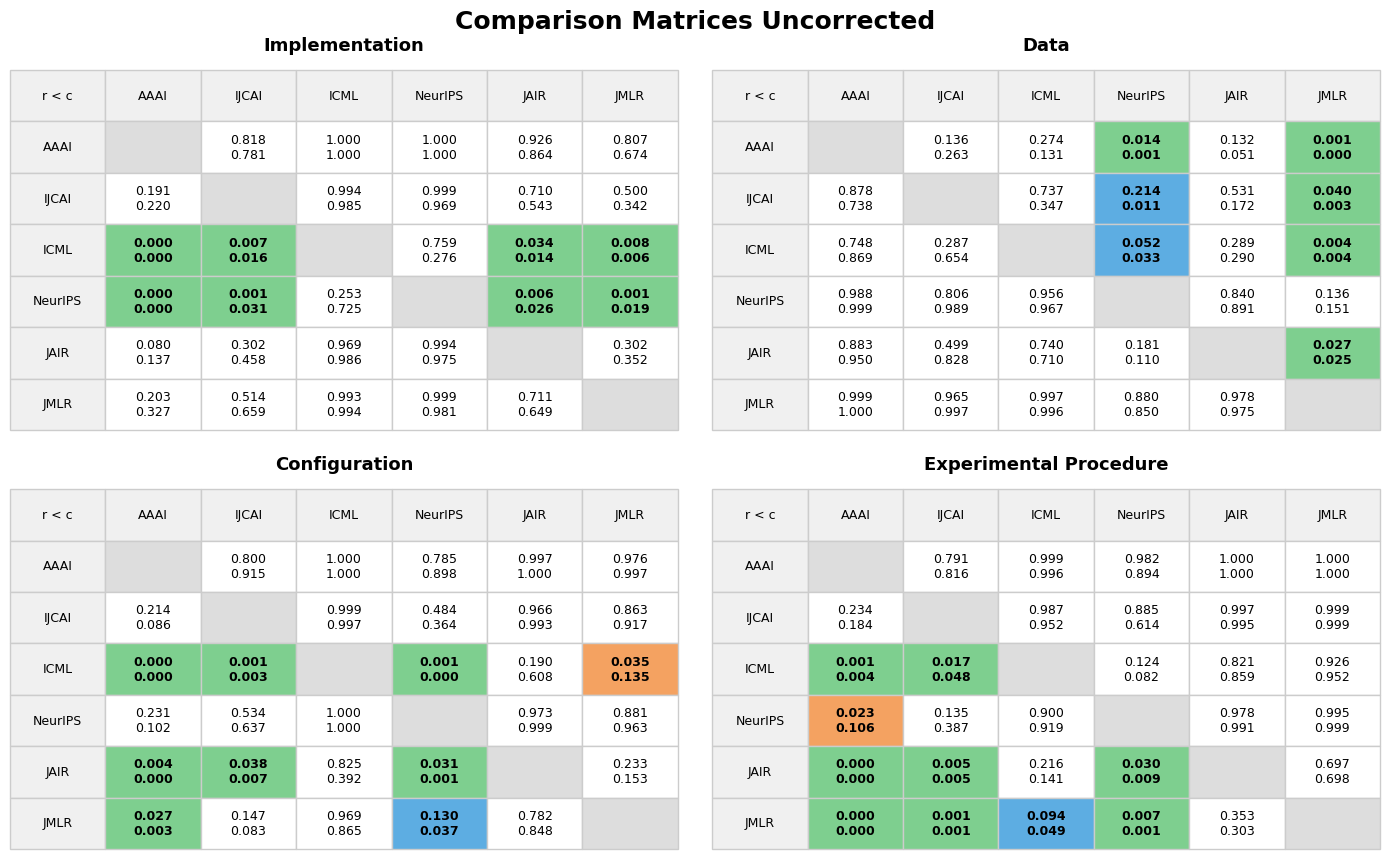

In [491]:
import numpy as np
import matplotlib.pyplot as plt

# Determine background color for each cell
def get_cell_color(i, j, p1, p2, significance_level):
    if i == j:
        return '#dddddd'  # grey for diagonal
    if p1 <= significance_level and p2 <= significance_level:
        return '#7ecf8f'  # green
    elif p1 <= significance_level:
        return '#f4a261'  # orange
    elif p2 <= significance_level:
        return '#5DADE2' # light blue
    else:
        return 'white'

# Render a table with proper layout
def show_table(ax, data, title, significance_level=0.05):
    ax.axis('off')
    ax.set_title(title, fontsize=13, fontweight='bold', pad=2, loc='center')

    n = data.shape[0]
    full_text = np.empty((n + 1, n + 1), dtype=object)
    full_colors = np.empty((n + 1, n + 1), dtype=object)
    font_styles = {}

    # Headers
    full_text[0, 0] = "r < c"
    full_text[0, 1:] = source_order
    full_text[1:, 0] = source_order
    full_colors[0, :] = "#f0f0f0"
    full_colors[:, 0] = "#f0f0f0"

    # Fill the cells
    for i in range(n):
        for j in range(n):
            if i == j:
                full_text[i + 1, j + 1] = ""  # blank out diagonal
            else:
                p1, p2 = data[i, j]
                full_text[i + 1, j + 1] = f"{p1:.3f}\n{p2:.3f}"
                if p1 <= significance_level or p2 <= significance_level:
                    font_styles[(i + 1, j + 1)] = 'bold'
            # Color all cells (including grey for diagonal)
            p1, p2 = data[i, j]
            full_colors[i + 1, j + 1] = get_cell_color(i, j, p1, p2, significance_level)

    # Draw table, manually placed lower
    table = ax.table(
        cellText=full_text,
        cellColours=full_colors,
        loc='center',
        cellLoc='center',
        edges='closed',
        bbox=[0, -0.2, 1, 1.15]
    )
    table.scale(1.2, 1.15)

    for key, cell in table.get_celld().items():
        cell.set_fontsize(9)
        cell.set_edgecolor('#cccccc')

        # Bold only for p-values ≤ 0.05
        if key in font_styles:
            cell.set_text_props(weight=font_styles[key])
        else:
            cell.set_text_props(weight='normal')

# Create figure and axes
fig, axes = plt.subplots(2, 2, figsize=(14, 9))
axes = axes.flatten()

# Render each of the 4 tables
for i, (data, title) in enumerate(zip(tables, dimensions)):
    show_table(axes[i], data, title)

# Layout adjustments
plt.suptitle("Comparison Matrices Uncorrected", fontsize=18, fontweight='bold', y=0.95)
plt.tight_layout(h_pad=2.0, w_pad=2.5)
plt.subplots_adjust(top=0.9)
plt.show()


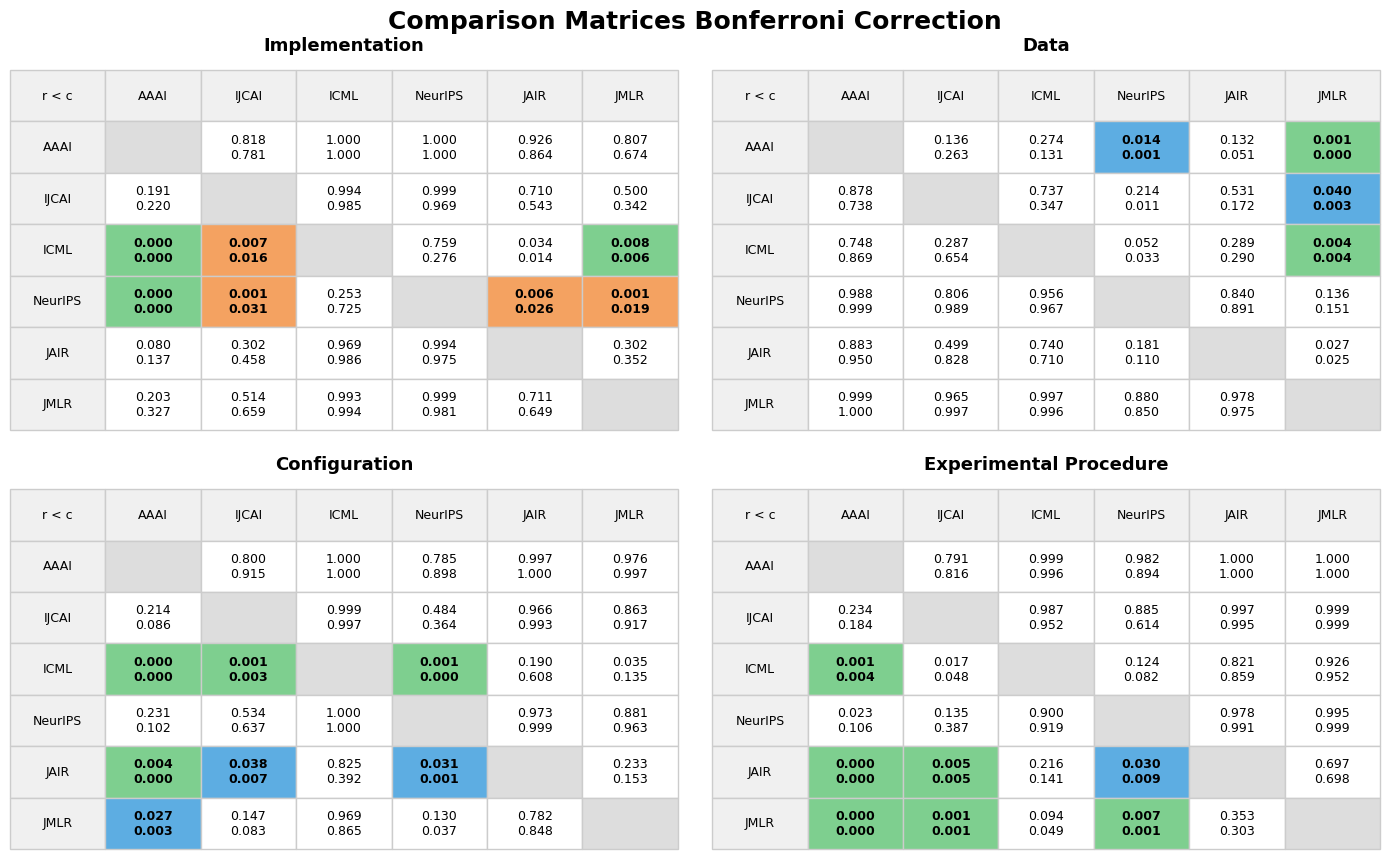

In [492]:
# Create figure and axes
fig, axes = plt.subplots(2, 2, figsize=(14, 9))
axes = axes.flatten()

# Render each of the 4 tables
for i, (data, title) in enumerate(zip(tables, dimensions)):
    show_table(axes[i], data, title, significance_level=0.05 / (len(source_order) - 1))

# Layout adjustments
plt.suptitle("Comparison Matrices Bonferroni Correction", fontsize=18, fontweight='bold', y=0.95)
plt.tight_layout(h_pad=2.0, w_pad=2.5)
plt.subplots_adjust(top=0.9)
plt.show()


## Insights from the Table

According to Permutation Test (Preferred) (We need to check distances):

Implementation:
- ICML and NeurIPS have better implementation documentation than AAAI, IJCAI and JMLR
- NeurIPS has better implementation documentation than JAIR

Data (Probably pratically insignificant): 
- AAAI and ICML have better Data documentation than JMLR

Configuration:
- ICML has better configuration documentation than AAAI, IJCAI and NeurIPS
- JAIR has better configuration documentation than AAAI

Experimental procedure (Probably pratically insignificant)
- ICML has better Experimental procedure documentation than AAAI
- JAIR has better Experimental procedure documentation than AAAI and IJCAI
- JMLR better Experimental procedure documentation than AAAI, IJCAI and NeurIPS


Given that Gundersen et al. (2025) have identified Data has the most important dimension, followed by Implementation
- ICML and NeurIPS are the least costly to reproduce, NeurIPS outperforming all other venues except ICML. ICML only outperforms AAAI. This indicates that in general ML conferences are better at implementation documentation than other sources, however the non-significance between ICML and IJCAI leaves an open question.
- Data is probably statistically significant but practically not (Check distances and plot)
- ICML excels at configuration documentation compared to other sources, including NeurIPS
- Exp. Proc mainly well documented by journals, and ICML also outperforms AAAI.